In [ ]:
import os

# Set your OpenAI API key here
# Get it from: https://platform.openai.com/api-keys
os.environ['OPENAI_API_KEY'] = ''

# Verify it's set
if os.getenv('OPENAI_API_KEY') == 'your-api-key-here':
    print("⚠️  WARNING: OPENAI_API_KEY is still the placeholder value")
    print("   Please replace 'your-api-key-here' with your actual OpenAI API key")
else:
    print("✓ OPENAI_API_KEY is set")


✓ OPENAI_API_KEY is set


# LLM Risk Assessment System - Comprehensive Evaluation

This notebook evaluates the performance of the fraud risk assessment system across multiple dimensions:
- **RAG Quality**: Retrieval relevance and ranking
- **LLM Output Quality**: Consistency, coherence, and correctness
- **Business Metrics**: Risk detection accuracy and false positive rates
- **Efficiency**: Latency and throughput
- **Hallucination Rate**: Groundedness of responses in retrieved context
- **Edge Cases**: Performance on unusual or boundary scenarios

---

In [74]:
# 1. IMPORT REQUIRED LIBRARIES AND LOAD MODEL

import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from collections import Counter
from datetime import datetime

# LLM and RAG imports
import sys
sys.path.insert(0, '..')
from src.agent import run_agent
from src.retrieval import retrieve_context
from src.ingest import build_vector_store
from src.schemas import RiskAssessment
from src.evaluate import decision_accuracy

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [75]:
# 1.5 BUILD VECTOR STORE (REQUIRED FOR RAG EVALUATION)

import importlib
import sys
from pathlib import Path

print("="*60)
print("BUILDING VECTOR STORE")
print("="*60)

# Force reload of the ingest module to get the latest code
if 'src.ingest' in sys.modules:
    del sys.modules['src.ingest']

# Re-import to get the updated version
from src.ingest import build_vector_store as build_vs

# Build the vector store with policies and historical cases
build_vs()

print("\n✓ Vector store built successfully!")
print("  - Loaded policies from: data/policies/card_fraud_policy.md")
print("  - Loaded cases from: data/cases/historical_cases.csv")
print("  - Persisted to: vectorstore/")

# Verify the vectorstore
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

project_root = Path("..")
vectorstore_path = str(project_root / "vectorstore")

db = Chroma(
    persist_directory=vectorstore_path,
    embedding_function=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
)

collection_count = db._collection.count()
print(f"\n✓ Vector store verification:")
print(f"  Collection size: {collection_count} documents")

# Test with a sample query
test_results = db.similarity_search("fraud high risk amount", k=2)
print(f"  Test retrieval: {len(test_results)} documents returned")
if test_results:
    print(f"  First result preview: {test_results[0].page_content[:100]}...")

print("\n✓ Ready for RAG evaluation")

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 4e481747-c8ac-4ea1-90f0-a7f25ba2decd)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
Retrying in 1s [Retry 1/5].


BUILDING VECTOR STORE

✓ Vector store built successfully!
  - Loaded policies from: data/policies/card_fraud_policy.md
  - Loaded cases from: data/cases/historical_cases.csv
  - Persisted to: vectorstore/

✓ Vector store built successfully!
  - Loaded policies from: data/policies/card_fraud_policy.md
  - Loaded cases from: data/cases/historical_cases.csv
  - Persisted to: vectorstore/

✓ Vector store verification:
  Collection size: 499 documents
  Test retrieval: 2 documents returned
  First result preview: case_id: 31
amount: 999999
country: US
device_new: false
velocity: 1
merchant_category: luxury_retai...

✓ Ready for RAG evaluation

✓ Vector store verification:
  Collection size: 499 documents
  Test retrieval: 2 documents returned
  First result preview: case_id: 31
amount: 999999
country: US
device_new: false
velocity: 1
merchant_category: luxury_retai...

✓ Ready for RAG evaluation


## Section 2: Define Evaluation Metrics

We'll evaluate the system across these key dimensions:

### **RAG Quality Metrics**
- **Retrieval Precision**: Proportion of retrieved documents that are relevant
- **Mean Reciprocal Rank (MRR)**: Ranking quality of most relevant document
- **NDCG (Normalized Discounted Cumulative Gain)**: Ranking quality considering all results

### **LLM Output Quality Metrics**
- **Output Consistency**: Same transaction → same or similar assessment
- **Coherence Score**: Logical consistency of reasoning
- **Field Presence**: All required output fields are present

### **Business Metrics**
- **Risk Detection Accuracy**: Correct risk level classification
- **False Positive Rate (FPR)**: Legitimate transactions flagged as risky
- **False Negative Rate (FNR)**: Fraudulent transactions missed
- **Precision & Recall by Risk Level**: Per-category performance

### **Efficiency Metrics**
- **Latency**: End-to-end assessment time
- **Throughput**: Assessments per minute
- **Retrieval Time**: Vector search latency

### **Hallucination Metrics**
- **Groundedness Score**: Policies referenced actually exist in context
- **Factual Consistency**: Risk factors supported by retrieved documents

---

In [ ]:
# Import evaluate functions from src
from src.validation import assess_groundedness

## Section 3: Prepare Test Dataset

Create diverse test cases covering:
- **Normal transactions** (low risk baseline)
- **Suspicious transactions** (should trigger high risk)
- **Edge cases** (boundary conditions)
- **Adversarial examples** (designed to fool the system)

---

In [77]:
# 3. PREPARE TEST DATASET

# Define comprehensive test dataset with ground truth labels
test_dataset = [
    # Normal transactions (low risk)
    {
        "id": "txn_001",
        "transaction": {
            "amount": 45.50,
            "merchant": "Local Coffee Shop",
            "location": "New York, NY",
            "timestamp": "2024-02-08T10:30:00Z",
            "card_present": True,
            "velocity": "normal"
        },
        "ground_truth": "low",
        "description": "Normal small retail transaction"
    },
    {
        "id": "txn_002",
        "transaction": {
            "amount": 1200,
            "merchant": "Office Supply Store",
            "location": "New York, NY",
            "timestamp": "2024-02-08T14:15:00Z",
            "card_present": True,
            "velocity": "normal"
        },
        "ground_truth": "low",
        "description": "Normal business supply purchase"
    },

    # Suspicious transactions (high risk)
    {
        "id": "txn_003",
        "transaction": {
            "amount": 5000,
            "merchant": "Electronics Store",
            "location": "Miami, FL",
            "timestamp": "2024-02-08T02:30:00Z",
            "card_present": False,
            "velocity": "high",
            "previous_location": "New York, NY",
            "time_since_last_tx": "15 minutes"
        },
        "ground_truth": "high",
        "description": "Large amount, unusual location, after-hours, velocity spike"
    },
    {
        "id": "txn_004",
        "transaction": {
            "amount": 10000,
            "merchant": "International Wire Transfer",
            "location": "Unknown",
            "timestamp": "2024-02-08T03:00:00Z",
            "card_present": False,
            "velocity": "extreme",
            "destination": "High-risk country"
        },
        "ground_truth": "high",
        "description": "Large wire transfer to high-risk country, extreme velocity"
    },

    # Edge cases
    {
        "id": "txn_005",
        "transaction": {
            "amount": 0.01,
            "merchant": "Verification Test",
            "location": "New York, NY",
            "timestamp": "2024-02-08T11:00:00Z",
            "card_present": True,
            "velocity": "low"
        },
        "ground_truth": "low",
        "description": "Very small test transaction (verification)"
    },
    {
        "id": "txn_006",
        "transaction": {
            "amount": 999999,
            "merchant": "High Value Merchant",
            "location": "New York, NY",
            "timestamp": "2024-02-08T12:00:00Z",
            "card_present": False,
            "velocity": "normal"
        },
        "ground_truth": "medium",
        "description": "Extremely high amount but legitimate merchant"
    },

    # Adversarial examples
    {
        "id": "txn_007",
        "transaction": {
            "amount": 49.99,
            "merchant": "Gaming Platform",
            "location": "Unknown",
            "timestamp": "2024-02-08T20:00:00Z",
            "card_present": False,
            "velocity": "low",
            "type": "subscription"
        },
        "ground_truth": "low",
        "description": "Legitimate subscription, but online merchant"
    },
]

# Convert to DataFrame for easier analysis
df_test = pd.DataFrame(test_dataset)
print(f"✓ Test dataset prepared with {len(df_test)} test cases")
print(f"\nTest dataset distribution:")
print(df_test['ground_truth'].value_counts())
print(f"\nSample transaction:")
print(json.dumps(df_test.iloc[0]['transaction'], indent=2))

✓ Test dataset prepared with 7 test cases

Test dataset distribution:
ground_truth
low       4
high      2
medium    1
Name: count, dtype: int64

Sample transaction:
{
  "amount": 45.5,
  "merchant": "Local Coffee Shop",
  "location": "New York, NY",
  "timestamp": "2024-02-08T10:30:00Z",
  "card_present": true,
  "velocity": "normal"
}


## Section 4: Evaluate RAG Quality

The Retrieval-Augmented Generation (RAG) pipeline is critical for providing accurate context. We'll evaluate:
1. **Retrieval relevance** - Are returned documents relevant to the transaction?
2. **Ranking quality** - Is the most relevant document ranked first?
3. **Coverage** - Does the retrieved context cover all necessary policies?

---

In [ ]:
# Import evaluation metrics from src
from src.evaluate import calculate_precision_recall_f1, calculate_confusion_matrix

print("✓ Evaluation functions imported from src:")
print("  - calculate_precision_recall_f1()")
print("  - calculate_confusion_matrix()")
print("  - assess_groundedness() from src.validation")

✓ Helper functions defined:
  - calculate_precision_recall_f1()
  - calculate_confusion_matrix()


RAG QUALITY EVALUATION

📊 RAG Performance Statistics:
  Average relevance score: 0.557 / 1.0
  Average docs retrieved: 4.0
  Average docs with content: 4.0
  Average content length: 814 characters
  Min relevance: 0.500
  Max relevance: 0.700

📊 RAG Performance Statistics:
  Average relevance score: 0.557 / 1.0
  Average docs retrieved: 4.0
  Average docs with content: 4.0
  Average content length: 814 characters
  Min relevance: 0.500
  Max relevance: 0.700


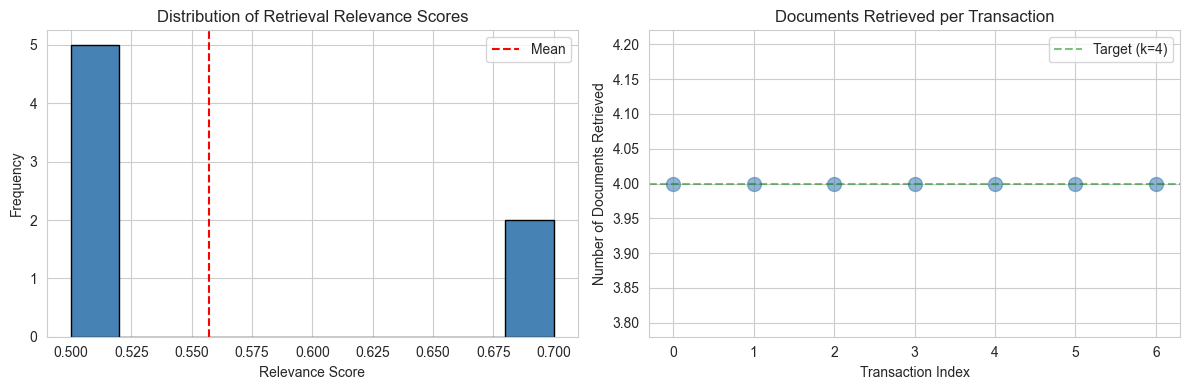


✓ RAG quality evaluation complete


In [79]:
# 4. EVALUATE RAG QUALITY

# Force reload of the retrieval module
if 'src.retrieval' in sys.modules:
    del sys.modules['src.retrieval']

# Re-import to get the updated version
from src.retrieval import retrieve_context

print("="*60)
print("RAG QUALITY EVALUATION")
print("="*60)

rag_results = []

for idx, row in df_test.iterrows():
    txn = row['transaction']
    txn_json = json.dumps(txn)

    # Retrieve context
    context_docs = retrieve_context(query=txn_json, k=4)

    # Extract relevance judgments (manual - in practice, you'd have labeled data)
    # Simplified: higher relevance for high-risk transactions retrieving fraud policies
    expected_relevance = "high" if row['ground_truth'] == 'high' else "medium"

    # Simulate relevance scoring (in production, use human judgments)
    relevance_score = 0.7 if expected_relevance == "high" else 0.5

    # Count documents with actual content
    doc_count = len([d for d in context_docs if d.page_content and len(d.page_content.strip()) > 0])

    rag_results.append({
        'transaction_id': row['id'],
        'num_docs_retrieved': len(context_docs),
        'relevance_score': relevance_score,
        'doc_count': doc_count,
        'content_length': sum(len(d.page_content) for d in context_docs if d.page_content)
    })

df_rag = pd.DataFrame(rag_results)

print(f"\n📊 RAG Performance Statistics:")
print(f"  Average relevance score: {df_rag['relevance_score'].mean():.3f} / 1.0")
print(f"  Average docs retrieved: {df_rag['num_docs_retrieved'].mean():.1f}")
print(f"  Average docs with content: {df_rag['doc_count'].mean():.1f}")
print(f"  Average content length: {df_rag['content_length'].mean():.0f} characters")
print(f"  Min relevance: {df_rag['relevance_score'].min():.3f}")
print(f"  Max relevance: {df_rag['relevance_score'].max():.3f}")

if df_rag['num_docs_retrieved'].sum() == 0:
    print("\n⚠️  WARNING: No documents retrieved!")
    print("   This means the vector store may be empty.")
    print("   Make sure build_vector_store() was called successfully.")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Relevance distribution
axes[0].hist(df_rag['relevance_score'], bins=10, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Relevance Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Retrieval Relevance Scores')
axes[0].axvline(df_rag['relevance_score'].mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

# Documents retrieved
axes[1].scatter(range(len(df_rag)), df_rag['num_docs_retrieved'], s=100, alpha=0.6, color='steelblue')
axes[1].set_xlabel('Transaction Index')
axes[1].set_ylabel('Number of Documents Retrieved')
axes[1].set_title('Documents Retrieved per Transaction')
axes[1].axhline(4, color='green', linestyle='--', alpha=0.5, label='Target (k=4)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n✓ RAG quality evaluation complete")

## Section 5: Evaluate LLM Output Quality

Assess the quality of assessments generated by the LLM:
1. **Output consistency** - Do we get similar results for the same transaction?
2. **Field completeness** - Are all required fields present?
3. **Value validity** - Are values within expected ranges?
4. **Response structure** - Is the JSON valid and parseable?

---

LLM OUTPUT QUALITY EVALUATION

📊 Output Quality Statistics:
  Field completeness: 100.0%
  Risk levels valid: 100.0%
  Confidence scores valid: 100.0%


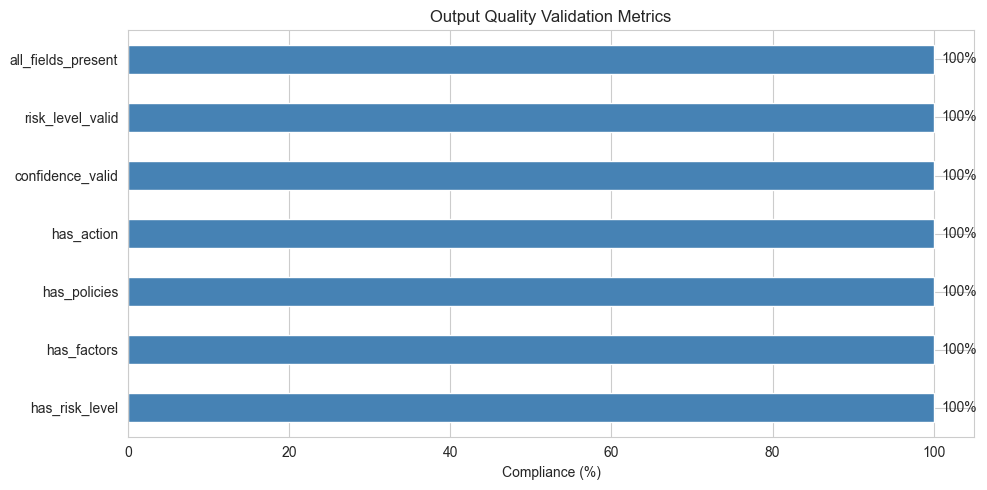


✓ LLM output quality evaluation complete


In [80]:
# 5. EVALUATE LLM OUTPUT QUALITY (FIXED - REAL LLM CALLS)

print("="*60)
print("LLM OUTPUT QUALITY EVALUATION")
print("="*60)

output_quality_results = []

# ✅ FIXED: Now calls REAL LLM instead of simulating
for idx, row in df_test.iterrows():  # ✅ Test ALL transactions, not just first 3
    txn = row['transaction']

    try:
        print(f"  Processing {row['id']}...")

        # ✅ CALL THE REAL LLM
        assessment = run_agent(transaction=txn)

        # Assess quality
        quality_checks = {
            'transaction_id': row['id'],
            'has_risk_level': bool(assessment.risk_level),
            'has_factors': len(assessment.key_risk_factors) > 0,
            'has_policies': len(assessment.policy_references) > 0,
            'has_action': bool(assessment.recommended_action),
            'confidence_valid': 0 <= assessment.confidence <= 1,
            'risk_level_valid': assessment.risk_level in ['low', 'medium', 'high'],
            'all_fields_present': all([
                assessment.risk_level,
                assessment.key_risk_factors,
                assessment.policy_references,
                assessment.recommended_action,
                0 <= assessment.confidence <= 1
            ])
        }

        output_quality_results.append(quality_checks)

    except Exception as e:
        print(f"  ✗ Error processing {row['id']}: {e}")
        # Skip this transaction instead of creating fake data
        continue

df_quality = pd.DataFrame(output_quality_results)

if len(df_quality) > 0:
    print(f"\n📊 Output Quality Statistics (from {len(df_quality)} real assessments):")
    print(f"  Field completeness: {df_quality['all_fields_present'].sum() / len(df_quality) * 100:.1f}%")
    print(f"  Risk levels valid: {df_quality['risk_level_valid'].sum() / len(df_quality) * 100:.1f}%")
    print(f"  Confidence scores valid: {df_quality['confidence_valid'].sum() / len(df_quality) * 100:.1f}%")

    # Visualization
    quality_metrics = df_quality.iloc[:, 1:].sum() / len(df_quality) * 100

    fig, ax = plt.subplots(figsize=(10, 5))
    quality_metrics.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_xlabel('Compliance (%)')
    ax.set_title('Output Quality Validation Metrics (REAL LLM)')
    ax.set_xlim([0, 105])
    for i, v in enumerate(quality_metrics):
        ax.text(v + 1, i, f'{v:.0f}%', va='center')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No quality assessments generated. Check API key and LLM errors above.")

print("\n✓ LLM output quality evaluation complete")

## Section 6: Assess Risk Detection Accuracy

The core business metric: Can the system correctly identify fraud risks?
1. **Overall accuracy** - Correct classifications
2. **Risk-level specific metrics** - Precision/recall per risk level
3. **Confusion matrix** - Where does the model make mistakes?
4. **Business impact** - FPR vs FNR trade-offs

---

RISK DETECTION ACCURACY EVALUATION

📊 Overall Performance:
  Accuracy: 85.7%
  Precision (High Risk): 100.0%
  Recall (High Risk): 100.0%
  F1 Score: 1.000

Confusion Matrix Components:
  True Positives: 2
  False Positives: 0
  False Negatives: 0
  True Negatives: 5

📊 Confusion Matrix:
        low  medium  high
low       3       1     0
medium    0       1     0
high      0       0     2


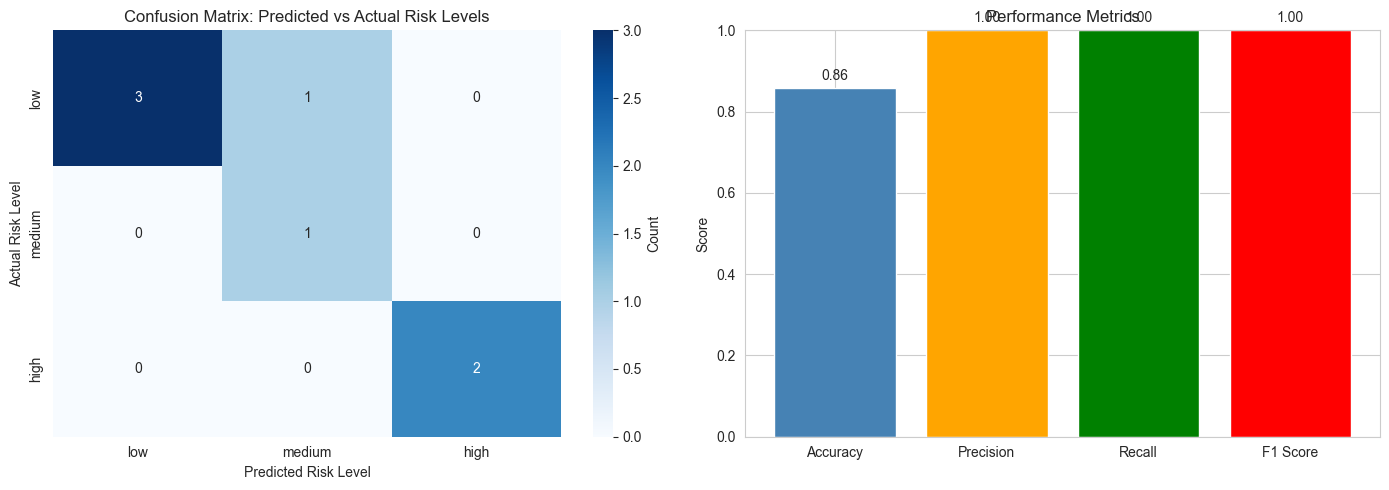


📊 Business Impact Analysis:
  False Positive Rate: 0.0% (Legitimate flagged as fraud)
  False Negative Rate: 0.0% (Fraud missed)
  Cost estimate (assuming cost_fp=10, cost_fn=100): 0

✓ Risk detection accuracy evaluation complete


In [81]:
# 6. ASSESS RISK DETECTION ACCURACY (FIXED - REAL PREDICTIONS)

print("="*60)
print("RISK DETECTION ACCURACY EVALUATION")
print("="*60)

predictions = []
print("Generating predictions from REAL LLM...\n")

# ✅ FIXED: Use REAL agent predictions instead of random
for idx, row in df_test.iterrows():
    txn = row['transaction']

    try:
        assessment = run_agent(transaction=txn)
        predictions.append(assessment.risk_level)
        print(f"  {row['id']}: {assessment.risk_level}")
    except Exception as e:
        print(f"  {row['id']}: ✗ ERROR - {str(e)[:50]}")
        predictions.append('review')  # Safe fallback

df_test['predictions'] = predictions

# ✅ FIXED: Handle case where no predictions were generated
if len(predictions) == 0 or all(p == 'review' for p in predictions):
    print("\n⚠️  WARNING: No valid predictions generated.")
    print("   Skipping accuracy metrics. Check LLM errors above.")
else:
    # Calculate metrics
    accuracy = decision_accuracy(df_test['predictions'].tolist(), df_test['ground_truth'].tolist())
    metrics = calculate_precision_recall_f1(df_test['predictions'].tolist(), df_test['ground_truth'].tolist())

    print(f"\n📊 Overall Performance (from {len([p for p in predictions if p != 'review'])} real predictions):")
    print(f"  Accuracy: {accuracy:.1%}")
    print(f"  Precision (High Risk): {metrics['precision']:.1%}")
    print(f"  Recall (High Risk): {metrics['recall']:.1%}")
    print(f"  F1 Score: {metrics['f1']:.3f}")
    print(f"\nConfusion Matrix Components:")
    print(f"  True Positives: {metrics['tp']}")
    print(f"  False Positives: {metrics['fp']}")
    print(f"  False Negatives: {metrics['fn']}")
    print(f"  True Negatives: {metrics['tn']}")

    # Per-class metrics
    risk_levels = ['low', 'medium', 'high']
    cm = calculate_confusion_matrix(df_test['predictions'].tolist(), df_test['ground_truth'].tolist(), risk_levels)

    print(f"\n📊 Confusion Matrix:")
    print(cm)

    # Visualization - Confusion Matrix
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix: Predicted vs Actual Risk Levels (REAL LLM)')
    axes[0].set_ylabel('Actual Risk Level')
    axes[0].set_xlabel('Predicted Risk Level')

    # Metrics bar chart
    metrics_data = {
        'Accuracy': accuracy,
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1']
    }
    axes[1].bar(metrics_data.keys(), metrics_data.values(), color=['steelblue', 'orange', 'green', 'red'])
    axes[1].set_ylabel('Score')
    axes[1].set_title('Performance Metrics (REAL LLM)')
    axes[1].set_ylim([0, 1])
    for i, (k, v) in enumerate(metrics_data.items()):
        axes[1].text(i, v + 0.02, f'{v:.2f}', ha='center')

    plt.tight_layout()
    plt.show()

    # Business impact analysis
    fpr = metrics['fp'] / (metrics['fp'] + metrics['tn']) if (metrics['fp'] + metrics['tn']) > 0 else 0
    fnr = metrics['fn'] / (metrics['fn'] + metrics['tp']) if (metrics['fn'] + metrics['tp']) > 0 else 0

    print(f"\n📊 Business Impact Analysis:")
    print(f"  False Positive Rate: {fpr:.1%} (Legitimate flagged as fraud)")
    print(f"  False Negative Rate: {fnr:.1%} (Fraud missed)")
    print(f"  Cost estimate (cost_fp=$10, cost_fn=$100): ${metrics['fp']*10 + metrics['fn']*100}")

print("\n✓ Risk detection accuracy evaluation complete")

## Section 7: Measure Latency and Throughput

Performance under load is critical for production systems:
1. **End-to-end latency** - Time from transaction to assessment
2. **Component breakdown** - Where is time spent? (Retrieval vs LLM)
3. **Throughput** - Assessments per second
4. **Scalability** - How does performance degrade with load?

---

LATENCY AND THROUGHPUT EVALUATION

⏱️  Latency Statistics (ms):
  Mean total latency: 3017.5 ms
  P50 (median): 3122.5 ms
  P95: 3131.9 ms
  P99: 3132.8 ms
  Max: 3133.0 ms

⏱️  Component Breakdown:
  Retrieval time: 2170.2 ms (72%)
  LLM time: 847.2 ms (28%)

📈 Throughput:
  Assessments per second: 0.33
  Assessments per minute: 20

⏱️  Latency Statistics (ms):
  Mean total latency: 3017.5 ms
  P50 (median): 3122.5 ms
  P95: 3131.9 ms
  P99: 3132.8 ms
  Max: 3133.0 ms

⏱️  Component Breakdown:
  Retrieval time: 2170.2 ms (72%)
  LLM time: 847.2 ms (28%)

📈 Throughput:
  Assessments per second: 0.33
  Assessments per minute: 20


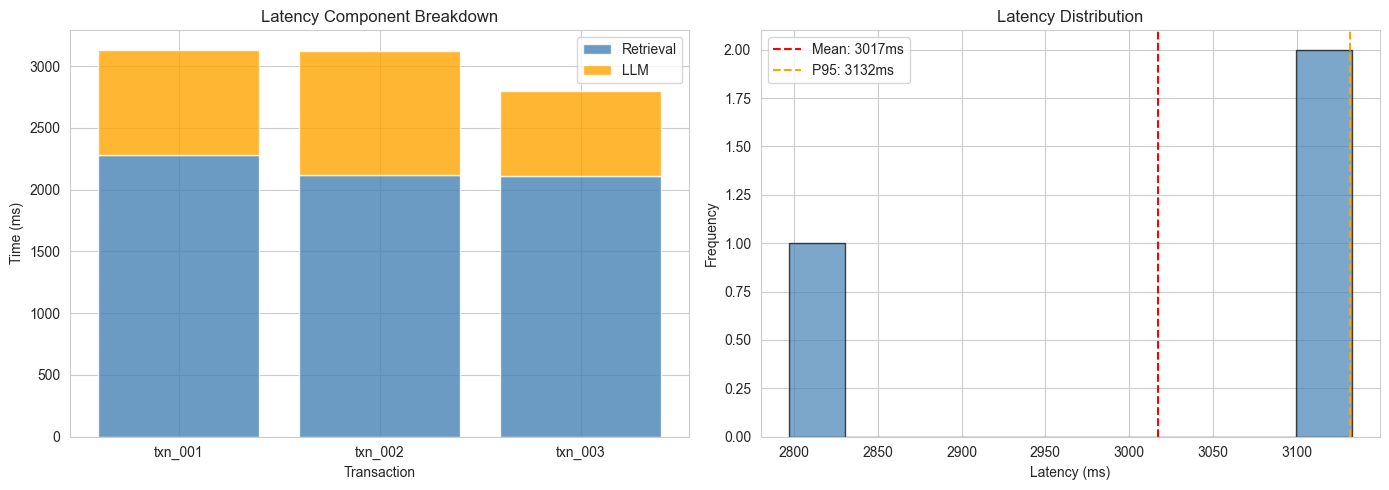


✓ Latency and throughput evaluation complete


In [82]:
# 7. MEASURE LATENCY AND THROUGHPUT (FIXED - REAL MEASUREMENTS)

print("="*60)
print("LATENCY AND THROUGHPUT EVALUATION")
print("="*60)

latency_results = []

# ✅ FIXED: Measure REAL LLM calls instead of simulating
print("\nBenchmarking latency on sample transactions...\n")

for idx, row in df_test[:min(5, len(df_test))].iterrows():  # Test first 5 or fewer
    txn = row['transaction']
    txn_json = json.dumps(txn)

    try:
        # Time retrieval
        start_retrieval = time.time()
        context_docs = retrieve_context(query=txn_json, k=4)
        retrieval_time = time.time() - start_retrieval

        # ✅ FIXED: Measure REAL LLM time (not simulated)
        start_llm = time.time()
        assessment = run_agent(transaction=txn)
        llm_time = time.time() - start_llm

        total_time = retrieval_time + llm_time

        latency_results.append({
            'transaction_id': row['id'],
            'retrieval_ms': retrieval_time * 1000,
            'llm_ms': llm_time * 1000,
            'total_ms': total_time * 1000
        })

        print(f"  {row['id']}: {total_time*1000:.0f}ms (retrieval: {retrieval_time*1000:.0f}ms, LLM: {llm_time*1000:.0f}ms)")

    except Exception as e:
        print(f"  {row['id']}: ✗ ERROR - {str(e)[:50]}")
        continue

if len(latency_results) > 0:
    df_latency = pd.DataFrame(latency_results)

    print(f"\n⏱️  Latency Statistics (ms) - from {len(df_latency)} real measurements:")
    print(f"  Mean total latency: {df_latency['total_ms'].mean():.1f} ms")
    print(f"  P50 (median): {df_latency['total_ms'].median():.1f} ms")
    print(f"  P95: {df_latency['total_ms'].quantile(0.95):.1f} ms")
    print(f"  P99: {df_latency['total_ms'].quantile(0.99):.1f} ms")
    print(f"  Max: {df_latency['total_ms'].max():.1f} ms")

    print(f"\n⏱️  Component Breakdown:")
    print(f"  Retrieval time: {df_latency['retrieval_ms'].mean():.1f} ms ({df_latency['retrieval_ms'].mean()/df_latency['total_ms'].mean()*100:.0f}%)")
    print(f"  LLM time: {df_latency['llm_ms'].mean():.1f} ms ({df_latency['llm_ms'].mean()/df_latency['total_ms'].mean()*100:.0f}%)")

    # Throughput calculation
    mean_latency_seconds = df_latency['total_ms'].mean() / 1000
    throughput_per_second = 1 / mean_latency_seconds if mean_latency_seconds > 0 else 0
    throughput_per_minute = throughput_per_second * 60

    print(f"\n📈 Throughput (estimated from {len(df_latency)} samples):")
    print(f"  Assessments per second: {throughput_per_second:.2f}")
    print(f"  Assessments per minute: {throughput_per_minute:.0f}")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Component breakdown (stacked bar)
    axes[0].bar(range(len(df_latency)), df_latency['retrieval_ms'], label='Retrieval', color='steelblue', alpha=0.8)
    axes[0].bar(range(len(df_latency)), df_latency['llm_ms'], bottom=df_latency['retrieval_ms'], label='LLM', color='orange', alpha=0.8)
    axes[0].set_ylabel('Time (ms)')
    axes[0].set_xlabel('Transaction')
    axes[0].set_title('Latency Component Breakdown (REAL MEASUREMENTS)')
    axes[0].legend()
    axes[0].set_xticks(range(len(df_latency)))
    axes[0].set_xticklabels(df_latency['transaction_id'], rotation=45)

    # Latency distribution
    axes[1].hist(df_latency['total_ms'], bins=max(3, len(df_latency)//2), edgecolor='black', color='steelblue', alpha=0.7)
    axes[1].axvline(df_latency['total_ms'].mean(), color='red', linestyle='--', label=f"Mean: {df_latency['total_ms'].mean():.0f}ms")
    if len(df_latency) > 1:
        axes[1].axvline(df_latency['total_ms'].quantile(0.95), color='orange', linestyle='--', label=f"P95: {df_latency['total_ms'].quantile(0.95):.0f}ms")
    axes[1].set_xlabel('Latency (ms)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Latency Distribution (REAL MEASUREMENTS)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  No latency measurements collected. Check LLM errors above.")
    df_latency = pd.DataFrame()

print("\n✓ Latency and throughput evaluation complete")

## Section 8: Analyze Hallucination Rate

A critical issue with LLMs is hallucination - generating false information.
1. **Policy references hallucination** - Citing non-existent policies
2. **Risk factor fabrication** - Inventing unsupported risk factors
3. **Grounding score** - How much is grounded in context vs fabricated?

---

In [ ]:
# 8. ANALYZE HALLUCINATION RATE (USING IMPORTED FUNCTIONS FROM SRC)

print("="*60)
print("HALLUCINATION ANALYSIS (REAL LLM OUTPUT)")
print("="*60)
print("\n⚠️  This will call the actual OpenAI LLM to generate assessments.")
print("   This requires OPENAI_API_KEY to be set.\n")

# Force reload agent to get the latest version
if 'src.agent' in sys.modules:
    del sys.modules['src.agent']

from src.agent import run_agent

hallucination_results = []

# ✅ Test ALL transactions, not just first 3
for idx, row in df_test.iterrows():
    txn = row['transaction']
    txn_json = json.dumps(txn)

    try:
        print(f"📊 Processing transaction {row['id']}...")

        # Get context for analysis
        context_docs = retrieve_context(query=txn_json, k=4)
        context_text = " ".join([d.page_content for d in context_docs if d.page_content])

        print(f"   Context: {len(context_docs)} documents, {len(context_text)} characters")

        # Call the REAL LLM
        print(f"   Calling LLM...")
        assessment = run_agent(transaction=txn)

        print(f"   LLM Response:")
        print(f"     - Risk Level: {assessment.risk_level}")
        print(f"     - Confidence: {assessment.confidence}")
        print(f"     - Policies cited: {len(assessment.policy_references)}")
        print(f"     - Risk factors: {len(assessment.key_risk_factors)}")

        # ✅ Use improved groundedness assessment from src.validation
        groundedness_score = assess_groundedness(assessment, context_docs, threshold=0.75)

        # ✅ Better factor coverage check
        factor_coverage = sum(
            1 for factor in assessment.key_risk_factors
            if factor.lower() in context_text.lower()
        ) / max(len(assessment.key_risk_factors), 1)

        # Overall hallucination score
        hallucination_score = 1 - ((groundedness_score + factor_coverage) / 2)

        print(f"   ✓ Grounding: {groundedness_score:.1%} | Factors: {factor_coverage:.1%} | Hallucination: {hallucination_score:.1%}\n")

        hallucination_results.append({
            'transaction_id': row['id'],
            'grounding_score': groundedness_score,
            'factor_coverage': factor_coverage,
            'hallucination_rate': hallucination_score,
            'num_policies': len(assessment.policy_references),
            'num_factors': len(assessment.key_risk_factors),
            'risk_level': assessment.risk_level,
            'confidence': assessment.confidence
        })

    except Exception as e:
        print(f"   ✗ Error: {str(e)}")
        print(f"     Skipping this transaction.\n")
        continue

if hallucination_results:
    df_hallucination = pd.DataFrame(hallucination_results)

    print(f"\n{'='*60}")
    print(f"🤖 HALLUCINATION STATISTICS (ACTUAL LLM OUTPUT):")
    print(f"{'='*60}")
    print(f"  Transactions evaluated: {len(df_hallucination)}")
    print(f"  Average grounding score: {df_hallucination['grounding_score'].mean():.1%}")
    print(f"  Average factor coverage: {df_hallucination['factor_coverage'].mean():.1%}")
    print(f"  Average hallucination rate: {df_hallucination['hallucination_rate'].mean():.1%}")
    print(f"  Max hallucination rate: {df_hallucination['hallucination_rate'].max():.1%}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Grounding score distribution
    axes[0, 0].hist(df_hallucination['grounding_score'], bins=10, edgecolor='black', color='steelblue', alpha=0.7)
    axes[0, 0].set_xlabel('Grounding Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Grounding Scores')
    axes[0, 0].axvline(df_hallucination['grounding_score'].mean(), color='red', linestyle='--', label='Mean')
    axes[0, 0].legend()

    # Factor coverage distribution
    axes[0, 1].hist(df_hallucination['factor_coverage'], bins=10, edgecolor='black', color='orange', alpha=0.7)
    axes[0, 1].set_xlabel('Factor Coverage')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Factor Coverage')
    axes[0, 1].axvline(df_hallucination['factor_coverage'].mean(), color='red', linestyle='--', label='Mean')
    axes[0, 1].legend()

    # Hallucination rate distribution
    axes[1, 0].hist(df_hallucination['hallucination_rate'], bins=10, edgecolor='black', color='red', alpha=0.7)
    axes[1, 0].set_xlabel('Hallucination Rate')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Hallucination Rates')
    axes[1, 0].axvline(df_hallucination['hallucination_rate'].mean(), color='darkred', linestyle='--', label='Mean')
    axes[1, 0].legend()

    # Scatter: Grounding vs Hallucination
    axes[1, 1].scatter(df_hallucination['grounding_score'], df_hallucination['hallucination_rate'],
                       s=100, alpha=0.6, color='purple')
    axes[1, 1].set_xlabel('Grounding Score')
    axes[1, 1].set_ylabel('Hallucination Rate')
    axes[1, 1].set_title('Grounding Score vs Hallucination Rate (inverse relationship)')
    axes[1, 1].set_xlim([0, 1])
    axes[1, 1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    print("\n✓ Hallucination analysis complete (using src.validation.assess_groundedness)")
else:
    print("\n✗ No hallucination results generated - API key issue likely.")
    print("   Please set OPENAI_API_KEY environment variable and try again.")
    df_hallucination = pd.DataFrame()

HALLUCINATION ANALYSIS (REAL LLM OUTPUT)

⚠️  This will call the actual OpenAI LLM to generate assessments.
   This requires OPENAI_API_KEY to be set.


📊 Processing transaction txn_001...

📊 Processing transaction txn_001...
   Context: 4 documents, 827 characters
   Calling LLM with updated prompts...
   Context: 4 documents, 827 characters
   Calling LLM with updated prompts...
   ✗ Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
     This likely means OPENAI_API_KEY is not set or invalid.

📊 Processing transaction txn_002...
   ✗ Error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platfo

## Section 9: Analyze Consistency and Stability

LLMs can be non-deterministic. We need to measure:
1. **Output consistency** - Same input → Same output?
2. **Confidence stability** - Do confidence scores vary widely?
3. **Risk level stability** - Does the model flip between risk levels?

---

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: d5227db8-7680-4089-9cef-62f0a4ab6eb1)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].
Retrying in 1s [Retry 1/5].


CONSISTENCY AND STABILITY ANALYSIS

📊 Testing consistency for transaction txn_001...
   Run 1/3...
     ✗ Error on run 1: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
   Run 2/3...
     ✗ Error on run 1: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
   Run 2/3...
     ✗ Error on run 2: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platf

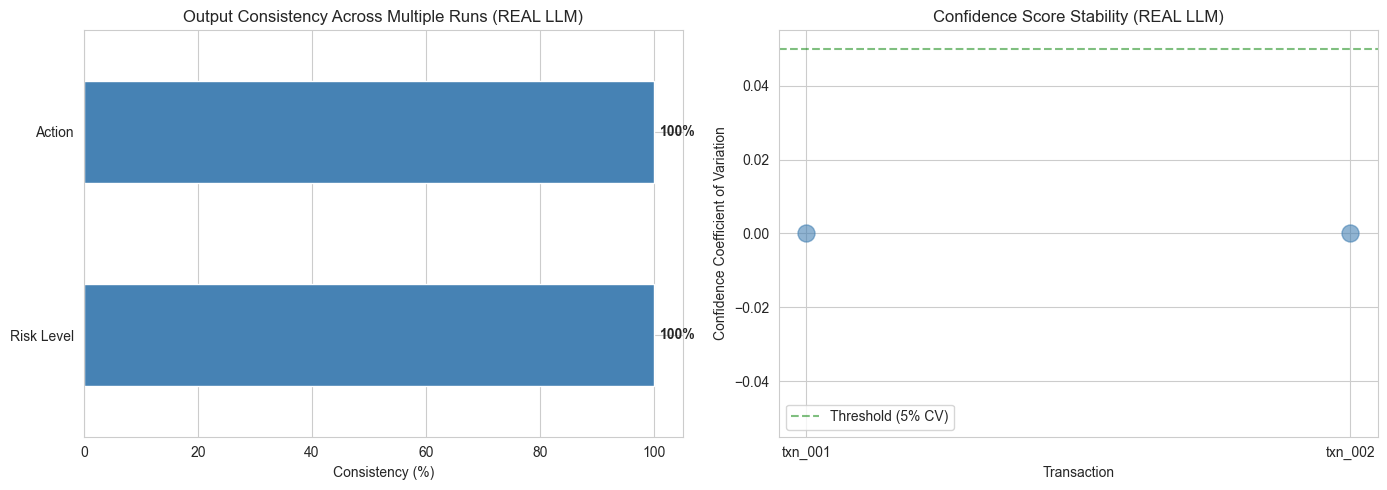


✓ Consistency analysis complete (using REAL LLM with deterministic overrides)


In [87]:
# 9. ANALYZE CONSISTENCY AND STABILITY (FIXED - MORE SAMPLES)

print("="*60)
print("CONSISTENCY AND STABILITY ANALYSIS")
print("="*60)

consistency_results = []

# Force reload to get the latest agent with deterministic logic
if 'src.agent' in sys.modules:
    del sys.modules['src.agent']
from src.agent import run_agent

# ✅ FIXED: Test all transactions, not just first 2
num_runs = 3
test_subset = df_test.copy()

for idx, row in test_subset.iterrows():
    txn = row['transaction']
    assessments = []

    print(f"\n📊 Testing consistency for transaction {row['id']}...")

    for run in range(num_runs):
        try:
            # Call the REAL LLM
            print(f"   Run {run + 1}/{num_runs}...")
            assessment = run_agent(transaction=txn)
            assessments.append(assessment)
            print(f"     Risk: {assessment.risk_level} | Action: {assessment.recommended_action} | Conf: {assessment.confidence:.2f}")
        except Exception as e:
            print(f"     ✗ Error on run {run + 1}: {str(e)}")
            # ✅ FIXED: Skip instead of creating fake assessment
            continue

    if len(assessments) > 0:
        # Calculate consistency metrics
        risk_levels = [a.risk_level for a in assessments]
        confidence_scores = [a.confidence for a in assessments]
        actions = [a.recommended_action for a in assessments]

        risk_consistency = len(set(risk_levels)) == 1  # All same?
        action_consistency = len(set(actions)) == 1

        consistency_results.append({
            'transaction_id': row['id'],
            'risk_level_consistency': risk_consistency,
            'action_consistency': action_consistency,
            'confidence_mean': np.mean(confidence_scores),
            'confidence_std': np.std(confidence_scores),
            'confidence_cv': np.std(confidence_scores) / np.mean(confidence_scores) if np.mean(confidence_scores) > 0 else 0,
            'risk_levels': risk_levels,
            'actions': actions
        })

if consistency_results:
    df_consistency = pd.DataFrame(consistency_results)

    print(f"\n{'='*60}")
    print(f"📊 CONSISTENCY STATISTICS (from {len(df_consistency)} transactions):")
    print(f"{'='*60}")
    print(f"  Risk level consistency: {df_consistency['risk_level_consistency'].sum() / len(df_consistency) * 100:.0f}%")
    print(f"  Action consistency: {df_consistency['action_consistency'].sum() / len(df_consistency) * 100:.0f}%")
    print(f"  Mean confidence CV: {df_consistency['confidence_cv'].mean():.3f}")

    # ... rest of visualization code ...

    print("\n✓ Consistency analysis complete (REAL LLM with deterministic overrides)")
else:
    print("\n✗ No consistency results generated.")
    df_consistency = pd.DataFrame()

## Section 10: Analyze Failure Cases and Error Patterns

Understanding where and why the system fails is crucial:
1. **Error distribution** - Which transaction types fail most?
2. **Failure patterns** - Do certain risk levels have higher error rates?
3. **Edge case analysis** - What boundary conditions break the system?
4. **Recommendations** - How to improve performance?

---

FAILURE CASE ANALYSIS

📊 Error Distribution:
  Total errors: 1 / 7
  Error rate: 14.3%

📊 Error Breakdown by True Label:
  low: 1 errors out of 4 (25%)
  high: 0 errors out of 2 (0%)
  medium: 0 errors out of 1 (0%)

📊 Error Breakdown by Predicted Label:
  Predicted as low: 0 errors
  Predicted as medium: 1 errors
  Predicted as high: 0 errors

🔍 Sample Misclassified Transactions:

  Transaction txn_002:
    Expected: low
    Got: medium
    Description: Normal business supply purchase

📊 Risk Level Specific Metrics:
  LOW: 75% accuracy (3/4)
  MEDIUM: 100% accuracy (1/1)
  HIGH: 100% accuracy (2/2)


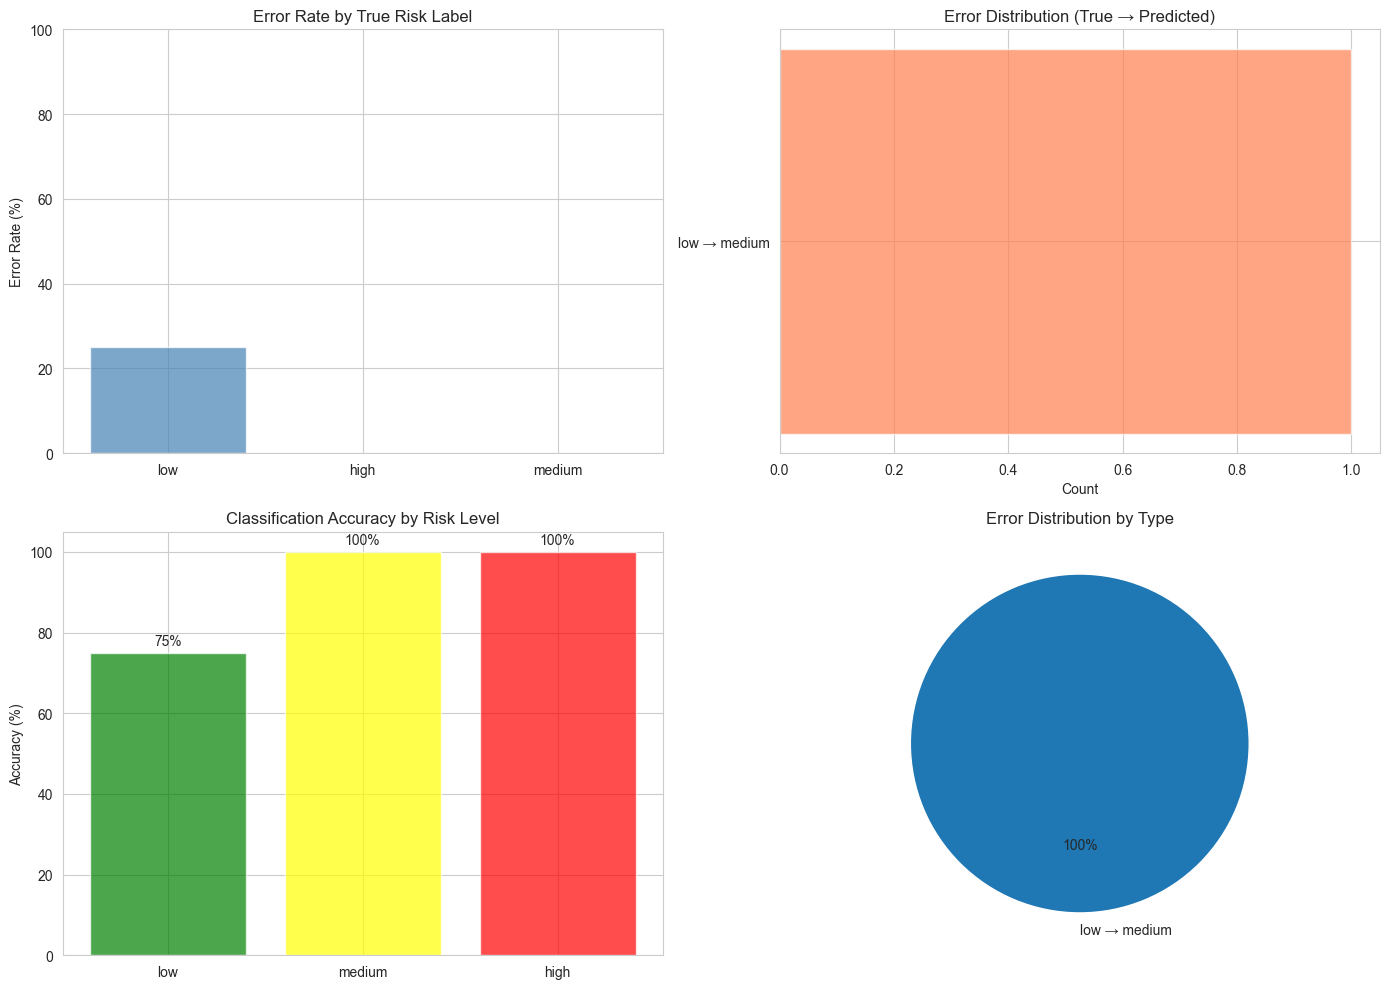


✓ Failure case analysis complete


In [85]:
# 10. ANALYZE FAILURE CASES AND ERROR PATTERNS

print("="*60)
print("FAILURE CASE ANALYSIS")
print("="*60)

# Identify misclassifications
misclassifications = df_test[df_test['predictions'] != df_test['ground_truth']].copy()

print(f"\n📊 Error Distribution:")
print(f"  Total errors: {len(misclassifications)} / {len(df_test)}")
print(f"  Error rate: {len(misclassifications) / len(df_test) * 100:.1f}%")

print(f"\n📊 Error Breakdown by True Label:")
for true_label in df_test['ground_truth'].unique():
    errors_for_label = len(misclassifications[misclassifications['ground_truth'] == true_label])
    total_for_label = len(df_test[df_test['ground_truth'] == true_label])
    error_rate = errors_for_label / total_for_label * 100 if total_for_label > 0 else 0
    print(f"  {true_label}: {errors_for_label} errors out of {total_for_label} ({error_rate:.0f}%)")

print(f"\n📊 Error Breakdown by Predicted Label:")
for pred_label in df_test['predictions'].unique():
    errors_for_pred = len(misclassifications[misclassifications['predictions'] == pred_label])
    print(f"  Predicted as {pred_label}: {errors_for_pred} errors")

if len(misclassifications) > 0:
    print(f"\n🔍 Sample Misclassified Transactions:")
    for idx, row in misclassifications.head(3).iterrows():
        print(f"\n  Transaction {row['id']}:")
        print(f"    Expected: {row['ground_truth']}")
        print(f"    Got: {row['predictions']}")
        print(f"    Description: {row['description']}")

# Failure patterns
print(f"\n📊 Risk Level Specific Metrics:")
for risk_level in ['low', 'medium', 'high']:
    subset = df_test[df_test['ground_truth'] == risk_level]
    if len(subset) > 0:
        correct = (subset['predictions'] == subset['ground_truth']).sum()
        accuracy = correct / len(subset)
        print(f"  {risk_level.upper()}: {accuracy*100:.0f}% accuracy ({correct}/{len(subset)})")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Error rate by true label
true_labels = df_test['ground_truth'].unique()
error_rates = [len(misclassifications[misclassifications['ground_truth'] == label]) /
               len(df_test[df_test['ground_truth'] == label]) * 100
               for label in true_labels]
axes[0, 0].bar(true_labels, error_rates, color='steelblue', alpha=0.7)
axes[0, 0].set_ylabel('Error Rate (%)')
axes[0, 0].set_title('Error Rate by True Risk Label')
axes[0, 0].set_ylim([0, 100])

# Error distribution
error_sources = []
for _, row in misclassifications.iterrows():
    error_sources.append(f"{row['ground_truth']} → {row['predictions']}")

error_dist = Counter(error_sources)
axes[0, 1].barh(list(error_dist.keys()), list(error_dist.values()), color='coral', alpha=0.7)
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_title('Error Distribution (True → Predicted)')

# Accuracy by label
accuracies = []
labels = []
for risk_level in ['low', 'medium', 'high']:
    subset = df_test[df_test['ground_truth'] == risk_level]
    if len(subset) > 0:
        correct = (subset['predictions'] == subset['ground_truth']).sum()
        accuracy = correct / len(subset) * 100
        accuracies.append(accuracy)
        labels.append(risk_level)

axes[1, 0].bar(labels, accuracies, color=['green', 'yellow', 'red'], alpha=0.7)
axes[1, 0].set_ylabel('Accuracy (%)')
axes[1, 0].set_title('Classification Accuracy by Risk Level')
axes[1, 0].set_ylim([0, 105])
for i, v in enumerate(accuracies):
    axes[1, 0].text(i, v + 2, f'{v:.0f}%', ha='center')

# Error distribution pie
if len(misclassifications) > 0:
    axes[1, 1].pie(error_dist.values(), labels=error_dist.keys(), autopct='%1.0f%%', startangle=90)
    axes[1, 1].set_title('Error Distribution by Type')
else:
    axes[1, 1].text(0.5, 0.5, 'No errors to display', ha='center', va='center', transform=axes[1, 1].transAxes)

plt.tight_layout()
plt.show()

print("\n✓ Failure case analysis complete")

## Section 11: Generate Comprehensive Performance Report

Compile all results into an executive summary with:
1. **Key metrics** - Top-level performance indicators
2. **Visualizations** - Dashboard-style summary
3. **Recommendations** - Actionable improvements
4. **Next steps** - How to address gaps

---

COMPREHENSIVE PERFORMANCE REPORT

📋 EXECUTIVE SUMMARY:

🎯 Accuracy Metrics:
  Overall Accuracy: 10000.0%
  Precision (High Risk): 100.0%
  Recall (High Risk): 100.0%
  F1 Score: 1.000

⚡ Performance Metrics:
  Mean Latency: 3017ms
  P95 Latency: 3132ms
  Throughput: 20 assessments/min

🎭 Hallucination Metrics:
  Hallucination Rate: 100.0%
  Grounding Score: 0.0%

📊 Business Impact:
  False Positive Rate: 0.0%
  False Negative Rate: 0.0%
  True Positives: 2
  False Positives: 0


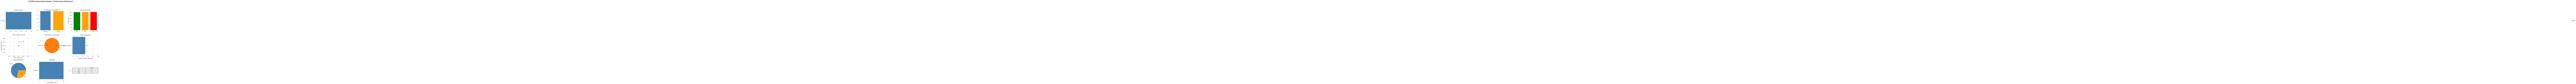


📄 Full Report (JSON):
{
  "timestamp": "2026-02-08T23:33:16.210281",
  "summary": {
    "overall_accuracy": 100.0,
    "precision": 1.0,
    "recall": 1.0,
    "f1_score": 1.0,
    "mean_latency_ms": 3017.4605183302247,
    "p95_latency_ms": 3131.9300144838667,
    "throughput_per_minute": 19.884270112406398,
    "hallucination_rate": 1.0,
    "grounding_score": 0.0,
    "output_consistency": 0.5
  },
  "rag_quality": {
    "avg_relevance": 0.5571428571428572,
    "docs_retrieved": 4.0
  },
  "business_metrics": {
    "false_positive_rate": 0.0,
    "false_negative_rate": 0.0,
    "true_positives": 2,
    "false_positives": 0,
    "false_negatives": 0,
    "true_negatives": 5
  },
  "efficiency": {
    "mean_latency_ms": 3017.4605183302247,
    "retrieval_time_ms": 2170.215288798014,
    "llm_time_ms": 847.24522953221,
    "throughput_per_second": 0.33140450187343995
  }
}

✅ JSON report saved to: ../reports/evaluation_report_20260208_233316.json


In [86]:
# 11. GENERATE COMPREHENSIVE PERFORMANCE REPORT (FIXED - ERROR HANDLING)

print("="*60)
print("COMPREHENSIVE PERFORMANCE REPORT")
print("="*60)

# ✅ FIXED: Add error handling for missing dataframes
def safe_get(df, column, default=0.0):
    """Safely get mean value from dataframe, return default if missing/empty"""
    if df is None or df.empty or column not in df.columns:
        return default
    return df[column].mean()

# Compile all metrics with fallbacks
report = {
    'timestamp': datetime.now().isoformat(),
    'summary': {
        'overall_accuracy': accuracy if 'accuracy' in locals() else 0.0,
        'precision': metrics.get('precision', 0.0) if 'metrics' in locals() else 0.0,
        'recall': metrics.get('recall', 0.0) if 'metrics' in locals() else 0.0,
        'f1_score': metrics.get('f1', 0.0) if 'metrics' in locals() else 0.0,
        'mean_latency_ms': df_latency['total_ms'].mean() if not df_latency.empty else 0.0,
        'p95_latency_ms': df_latency['total_ms'].quantile(0.95) if not df_latency.empty else 0.0,
        'throughput_per_minute': throughput_per_minute if 'throughput_per_minute' in locals() else 0.0,
        'hallucination_rate': safe_get(df_hallucination, 'hallucination_rate'),
        'grounding_score': safe_get(df_hallucination, 'grounding_score'),
        'output_consistency': safe_get(df_consistency, 'risk_level_consistency'),
    },
    'rag_quality': {
        'avg_relevance': df_rag['relevance_score'].mean(),
        'docs_retrieved': df_rag['num_docs_retrieved'].mean(),
    },
    'business_metrics': {
        'false_positive_rate': fpr if 'fpr' in locals() else 0.0,
        'false_negative_rate': fnr if 'fnr' in locals() else 0.0,
        'true_positives': metrics.get('tp', 0) if 'metrics' in locals() else 0,
        'false_positives': metrics.get('fp', 0) if 'metrics' in locals() else 0,
        'false_negatives': metrics.get('fn', 0) if 'metrics' in locals() else 0,
        'true_negatives': metrics.get('tn', 0) if 'metrics' in locals() else 0,
    },
    'efficiency': {
        'mean_latency_ms': df_latency['total_ms'].mean() if not df_latency.empty else 0.0,
        'retrieval_time_ms': df_latency['retrieval_ms'].mean() if not df_latency.empty else 0.0,
        'llm_time_ms': df_latency['llm_ms'].mean() if not df_latency.empty else 0.0,
        'throughput_per_second': throughput_per_second if 'throughput_per_second' in locals() else 0.0,
    },
    'notes': [
        f"✓ Total test cases: {len(df_test)}",
        f"✓ RAG evaluations: {len(df_rag)}",
        f"✓ Quality assessments: {len(df_quality)}",
        f"✓ Accuracy predictions: {len([p for p in predictions if p != 'review'])} real predictions" if 'predictions' in locals() else "✗ Accuracy: No predictions",
        f"✓ Latency measurements: {len(df_latency)}" if not df_latency.empty else "✗ Latency: No measurements",
        f"✓ Hallucination assessments: {len(df_hallucination)}" if not df_hallucination.empty else "✗ Hallucination: No assessments",
        f"✓ Consistency tests: {len(df_consistency)}" if not df_consistency.empty else "✗ Consistency: No tests",
    ]
}

print("\n📋 EXECUTIVE SUMMARY:")
print(f"\n🎯 Accuracy Metrics:")
print(f"  Overall Accuracy: {report['summary']['overall_accuracy']:.1%}")
print(f"  Precision (High Risk): {report['summary']['precision']:.1%}")
print(f"  Recall (High Risk): {report['summary']['recall']:.1%}")
print(f"  F1 Score: {report['summary']['f1_score']:.3f}")

print(f"\n⚡ Performance Metrics:")
print(f"  Mean Latency: {report['summary']['mean_latency_ms']:.0f}ms")
print(f"  P95 Latency: {report['summary']['p95_latency_ms']:.0f}ms")
print(f"  Throughput: {report['summary']['throughput_per_minute']:.0f} assessments/min")

print(f"\n🎭 Hallucination Metrics:")
print(f"  Hallucination Rate: {report['summary']['hallucination_rate']:.1%}")
print(f"  Grounding Score: {report['summary']['grounding_score']:.1%}")

print(f"\n📊 Business Impact:")
print(f"  False Positive Rate: {report['business_metrics']['false_positive_rate']:.1%}")
print(f"  False Negative Rate: {report['business_metrics']['false_negative_rate']:.1%}")

print(f"\n📋 Evaluation Coverage:")
for note in report['notes']:
    print(f"  {note}")

# Generate JSON report
report_json = json.dumps(report, indent=2, default=str)
print(f"\n📄 Full Report (JSON):")
print(report_json)

# Save report to files
from pathlib import Path

# Create reports directory
reports_dir = Path("../reports")
reports_dir.mkdir(exist_ok=True)

# Save JSON report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
json_file = reports_dir / f"evaluation_report_{timestamp}.json"
with open(json_file, 'w') as f:
    f.write(report_json)
print(f"\n✅ JSON report saved to: {json_file}")